In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm
from tqdm import trange
from visdom import Visdom

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('use: ',device)

use:  cuda


In [17]:
batch_size = 256

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=False, drop_last=True)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size, shuffle=False, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [18]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [19]:
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
    #nn.init.xavier_uniform(m.weight)
    if type(m.bias) != type(None):
        nn.init.constant_(m.bias.data, 0)
   
  elif classname.find('Conv') != -1:
    #nn.init.xavier_uniform(m.weight)
    if type(m.bias) != type(None):
        nn.init.constant_(m.bias.data, 0)
        
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [20]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())

    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [21]:
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            #nn.Linear(512, 512), # 32x32 img -> MaxPool:5 = 1x1xC(output)
            #nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10))
        '''
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # type 맞으면 True
                print('kernel_size[0] :',m.kernel_size[0])
                print('kernel_siez[1] :',m.kernel_size[1])
                print('outchannel: ',m.out_channels )
                print('---')
        '''
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           #nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
                
        return nn.Sequential(*layers)

In [22]:
model = VGG('VGG11').to(device)
model.apply(init_weights)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [23]:
model.state_dict()['features.0.bias']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [24]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [25]:
total_batch = len(trainloader)
print(f' total_batch : {total_batch}')

 total_batch : 195


Loss : 2.303:   0%|          | 0/30 [00:19<?, ?it/s]

epoch:   0, lr=0.010000


Loss : 1.901:  33%|███▎      | 10/30 [03:43<06:49, 20.45s/it]

epoch:  10, lr=0.010000


Loss : 1.280:  67%|██████▋   | 20/30 [07:07<03:25, 20.51s/it]

epoch:  20, lr=0.010000


Loss : 0.665: 100%|██████████| 30/30 [10:15<00:00, 20.51s/it]


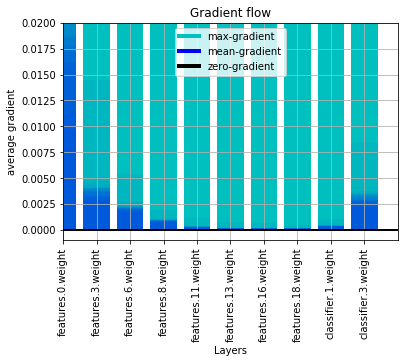

In [27]:
training_epoch =  30
train_acc_list = []
test_acc_list = []
pbar = trange(training_epoch, desc='Loss : 0', leave=True, position=0)

for epoch in pbar:
    train_acc = 0
    test_acc = 0
    model.train()
    for X,y in trainloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        plot_grad_flow(model.named_parameters())
        optimizer.step()
        train_acc += (output.argmax(1)==y).float().mean()
        #break
    train_acc_list.append(train_acc/total_batch) #acc per epoch
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        if epoch%10 == 0:
            print('epoch: {:3d}, lr={:.6f}'.format(epoch, lr))
    scheduler.step(loss)
    model.eval()
    pbar.set_description("Loss : %.3f" % loss)
    for X,y in testloader:
        with torch.no_grad():
            X = X.to(device)
            y = y.to(device)
            result = model(X)
            test_acc += (result.argmax(1)==y).float().mean()
            #break
    test_acc_list.append(test_acc/len(testloader))

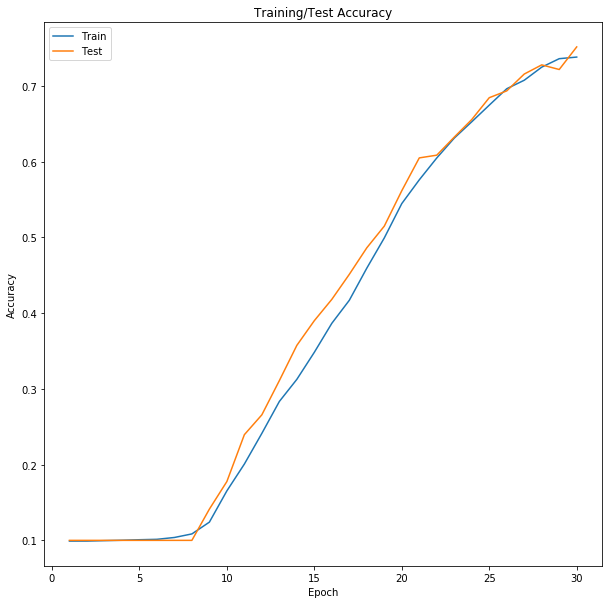

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Training/Test Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.plot(range(1, len(train_acc_list)+1), train_acc_list)
ax.plot(range(1, len(test_acc_list)+1), test_acc_list)
ax.legend(['Train', 'Test'])
plt.show()